In [4]:
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np


In [301]:
ddir = '/Users/lipovsky/is2-data'
file_list = os.listdir(ddir)
files = [f for f in file_list if f.endswith('.h5')]

t = list()
lat_lon_h = list()


for f in files:
    # f = files[0]
    print(f)

    #-- read specified file
    FILE_NAME = os.path.join(ddir,f)
    fid = h5py.File(FILE_NAME, mode='r')

    #-- determine which beam is the strong beam (left or right)
    if fid['gt1l'].attrs['atlas_beam_type'] == 'strong':
        strong_id = 'l'
    else:
        strong_id = 'r'


    #-- loop all three beam pairs and save all three
    for i in range(1,4):
        try:
            h_li = fid['gt%i%s/land_ice_segments/h_li'%(i,strong_id)][:]
            h_lat = fid['gt%i%s/land_ice_segments/latitude'%(i,strong_id)][:]
            h_lon = fid['gt%i%s/land_ice_segments/longitude'%(i,strong_id)][:]
            h_li_sigma = fid['gt%i%s/land_ice_segments/h_li_sigma'%(i,strong_id)][:]
            t.append( fid['/ancillary_data/data_start_utc'])
            lat_lon_h.append({"lat": h_lat,"lon": h_lon,"h": h_li,"h_sig": h_li_sigma })
            
        except KeyError:
            print('Key Error')

#     fid.close()

processed_ATL06_20190116000934_02830210_003_01.h5
processed_ATL06_20190205121557_05960212_003_01.h5
processed_ATL06_20181213145516_11600112_003_01.h5
processed_ATL06_20181218013336_12280110_003_01.h5
processed_ATL06_20190515073853_07180312_003_01.h5
processed_ATL06_20190115132257_02760212_003_01.h5
processed_ATL06_20190420194112_03440310_003_01.h5
processed_ATL06_20190306105157_10380212_003_01.h5
Key Error
Key Error
processed_ATL06_20190605063131_10380312_003_01.h5
Key Error
Key Error
processed_ATL06_20190613170129_11670310_003_01.h5
Key Error
processed_ATL06_20190314103516_11600212_003_01.h5
processed_ATL06_20181017042950_02830110_003_01.h5
processed_ATL06_20181016174312_02760112_003_01.h5
processed_ATL06_20181217144658_12210112_003_01.h5
processed_ATL06_20190408091936_01540312_003_01.h5
Key Error
processed_ATL06_20181123024916_08470110_003_01.h5
Key Error
Key Error
processed_ATL06_20181222012517_12890110_003_01.h5
processed_ATL06_20190416090254_02760312_003_01.h5
Key Error
processed_

<IPython.core.display.Javascript object>


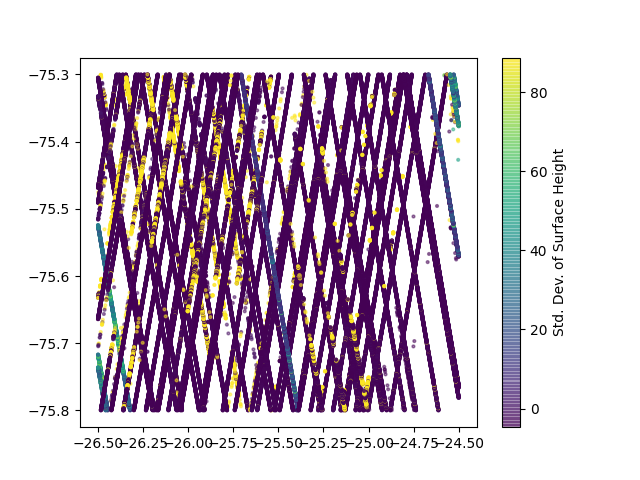

In [307]:
fig, ax = plt.subplots()
for pt in lat_lon_h:
    sct = plt.scatter(pt['lon'],pt['lat'],s=4, alpha=0.5,c=np.log(pt['h_sig']))
cbar = fig.colorbar(sct)
cbar.set_label('Std. Dev. of Surface Height')

In [309]:
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031")
xyh = list()
for ll in lat_lon_h:
    [x,y] = transformer.transform(ll['lat'] , ll['lon'])
    xyh.append([x,y,ll['h'],ll['h_sig']])

<IPython.core.display.Javascript object>


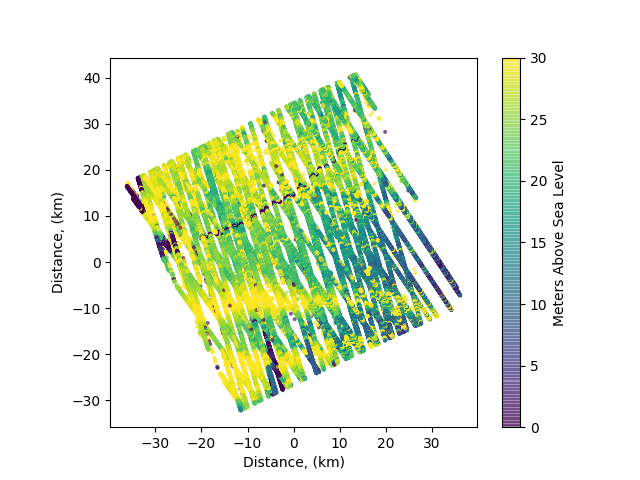

Text(0.5, 0, 'Distance, (km)')

In [310]:
fig, ax = plt.subplots()
x0 = 680
y0=-1420
for pt in xyh:
    sc = plt.scatter(x0+pt[0]/1e3,y0+pt[1]/1e3,s=4, alpha=0.5,c=pt[2],vmin=0, vmax=30)
ax.set_aspect('equal')
cbar = fig.colorbar(sc)
cbar.set_label('Meters Above Sea Level')
plt.ylabel('Distance, (km)')
plt.xlabel('Distance, (km)')

<IPython.core.display.Javascript object>


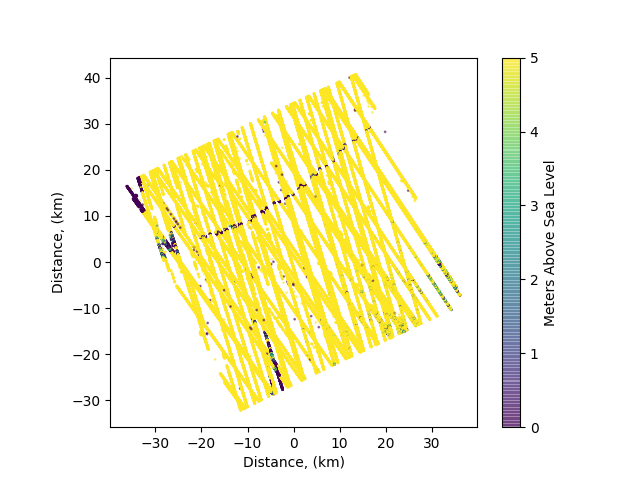

Text(0.5, 0, 'Distance, (km)')

In [320]:
# Same plot, but with uncertain points removed
fig, ax = plt.subplots()
x0 = 680
y0=-1420
for pt in xyh:
    i = pt[3]<1
    sc = plt.scatter(x0+pt[0][i]/1e3,y0+pt[1][i]/1e3,s=1, alpha=0.5,c=pt[2][i],vmin=0, vmax=5)
ax.set_aspect('equal')
cbar = fig.colorbar(sc)
cbar.set_label('Meters Above Sea Level')
plt.ylabel('Distance, (km)')
plt.xlabel('Distance, (km)')

In [293]:
def find_the_rifts(trace):
    
    thr = 1
    
    # Melange is visible as near zero m above sea level
    melange = np.where(trace < thr)
    melange = melange[0]
    
    if len(melange) < 2:
        return []
    
    start = np.nan
    stop = np.nan
    
    segments=[]
    mx=np.max(melange)

    # now create a list with the format ((seg1start,seg1stop),(seg2start,seg2stop),...)
    for i in range(len(melange)):
        if i == 0:
            start = melange[i]
            
        if i == len(melange)-1:
            stop = melange[i]
            segments.append((start,stop))
            return segments
        
        if melange[i+1] > melange[i]+1:
            stop = melange[i]
            segments.append((start,stop))
#             print("Added {strt} , {stp}".format(strt=start,stp=stop))
            start = melange[i+1]
            stop = np.nan
            
    return segments
        
def convert_to_centroid(rift_list,x,y):
    centroid_x = list()
    centroid_y = list()
    width = list()
    
    for r in rift_list:
        centroid_x.append( (x[r[0]] + x[r[1]])/2 )
        centroid_y.append( (y[r[0]] + y[r[1]])/2 )
        width.append( np.sqrt((x[r[0]] - x[r[1]])**2 + (y[r[0]] - y[r[1]])**2) )
        
    rift_data = {
        "x-centroid": centroid_x,
        "y-centroid": centroid_y,
        "width": width
    }
        
    return rift_data

In [294]:
# index = 3
# rift_list = find_the_rifts(xyh[index][2])
# if len(rift_list) > 0:
#     output = convert_to_centroid(rift_list,xyh[index][0],xyh[index][1])

rift_obs = {
    "x-centroid": [],
    "y-centroid": [],
    "width": []
}

for i in range(len(xyh)):
    rift_list = find_the_rifts(xyh[i][2])
    if len(rift_list) > 0:
        output = convert_to_centroid(rift_list,xyh[i][0],xyh[i][1])
        rift_obs['x-centroid'].extend( output['x-centroid'] )
        rift_obs['y-centroid'].extend( output['y-centroid'] )
        rift_obs['width'].extend( output['width'] )


<IPython.core.display.Javascript object>


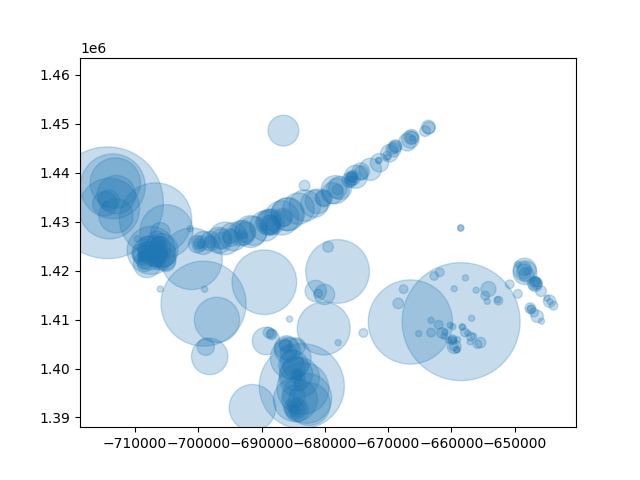

In [321]:
fig, ax = plt.subplots()
plt.scatter(rift_obs['x-centroid'],rift_obs['y-centroid'],s=rift_obs['width'],alpha=0.25)

In [281]:
?plt.scatter